In [6]:
import iris
import numpy as np
import xarray as xr
import calendar
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path
import calendar
plt.rcParams['mathtext.default'] = 'regular'

In [7]:
# Read data
path_to_cmip = Path('../../external_data/GFED')
path_to_ukca = Path('../data')
cmip = xr.open_dataset(path_to_cmip / 'CO-em-biomassburning_input4MIPs_emissions_CMIP_VUA-CMIP-BB4CMIP6-1-2_gn_185001-201512.nc')
ukca = iris.load_cube(str(path_to_ukca / 'xmeka' / 'xmeka_o3.nc'))

In [ ]:
# for n, i in enumerate(cmip.time.values[-36:-24]):
#     print(n+1, i.strftime()[0:10])

In [ ]:
co = cmip.CO.isel(time=slice(0,12)).to_iris()
co

In [ ]:
# Guess coordinate bounds
for coord in ['longitude', 'latitude']:
    if not co.coord(coord).has_bounds():
        co.coord(coord).guess_bounds()
    if not co.coord(coord).has_bounds():
        co.coord(coord).guess_bounds()
# Calculate emission per year by weighting monthly values by month's length and adding values up
n_days_per_month = np.asarray([calendar.monthrange(2013, i)[1] for i in range(1, 13)]) # number of days in each month in year 2013
cmip_month_weights = iris.util.broadcast_to_shape(n_days_per_month, co.shape, (0,)) # weight of each month's length
co_emis_per_year = (co * 
                             iris.coords.AuxCoord(86400, units='s', long_name='seconds_per_day')).collapsed(['time'],
                                                                                                            iris.analysis.SUM,
                                                                                                            weights=cmip_month_weights)

# Add up all grid cells accounting for their varying area sizes
cmip_norm_area_weights = iris.analysis.cartography.area_weights(co_emis_per_year, normalize=True)
co_emis_per_year_area_sum = co_emis_per_year.collapsed(['longitude', 'latitude'], 
                                                                         iris.analysis.SUM,
                                                                         weights=cmip_norm_area_weights)

In [ ]:
# Calculate Earth's area
area_weights = iris.analysis.cartography.area_weights(co_emis_per_year, normalize=False)
earth_area = iris.cube.Cube(area_weights.sum(), units='m2')

In [ ]:
arr = co_emis_per_year_area_sum * earth_area
arr.convert_units('Gg')

In [ ]:
(arr.data*6.8*1e-7)

#### Using h5py

In [8]:
import h5py

From README:

'The emissions group contains, for 12 months (01,02,..,12), 5 datasets: emissions (carbon with units of g C m-2 month-1 and DM with units of kg DM m-2 month-1), small_fire_fraction (unitless), daily fraction (unitless), diurnal cycle (unitless), as well as a group partitioning which contains, for both C and DM, the datasets (all unitless):
- SAVA (Savanna, grassland and shrubland fires)
- BORF (Boreal forest fires)
- TEMF (Temperature forest fires)
- DEFO (Tropical forest fires [deforestation and degradation])
- PEAT (Peat fires)
- AGRI (Agricultural waste burning)'

Burdned area group contains two variables: burned_fraction and source. burned_fraction is the fraction of each grid cell that burned in that month according to the GFED4s burned area data, burned_area_source indicates what data was used to construct the burned area maps excluding small fires'.

In [9]:
path_to_gfed = Path('../../external_data/GFED')

In [10]:
# Extract data on total dry matter emissions and source partitioning
group_name = 'emissions'
main_var = 'DM'
auxi_vars = ['AGRI', 'BORF', 'DEFO', 'PEAT', 'SAVA', 'TEMF', ]

monthly_dict = {}
monthly_dict[main_var] = []
for auxi_var in auxi_vars:
    monthly_dict[auxi_var] = []

for fpath in sorted(path_to_gfed.glob('*hdf5')):    
    arr_dict = {}
    arr_dict[main_var] = []
    for auxi_var in auxi_vars:
        arr_dict[auxi_var] = []

    with h5py.File(fpath, 'r') as f:
        lons = f['lon'].value[0, :]
        lats = f['lat'].value[:, 0]
        grid_cell_area = f['/ancill/grid_cell_area'].value
        xr_coord_dims = dict(coords=dict(lon=lons, lat=lats), dims=('lat', 'lon'))

        for month in f[group_name].keys():
            # Read dry matter monthly emissions
            arr_dict[main_var].append(xr.DataArray(f[group_name][month][main_var].value, 
                                                   name=f'{main_var}'.lower(), 
                                                   **xr_coord_dims))
            # Read monthly data on the fraction the specific source contributes to dry matter emissions
            for auxi_var in auxi_vars:
                arr_dict[auxi_var].append(xr.DataArray(f[group_name][month]['partitioning'][f'{main_var}_{auxi_var}'].value,
                                                       name=f'{main_var}_{auxi_var}'.lower(),
                                                       **xr_coord_dims))
        for key, val in arr_dict.items():
            monthly_dict[key].append(xr.concat(val, dim='month'))

    yearly_dict = {}
    for key, val in monthly_dict.items():
        yearly_dict[key] = xr.concat(val, dim='year')
        
# Combine all data into an xarray dataset
gfed_ds = xr.Dataset(yearly_dict)

In [19]:
gfed_ds

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, month: 12, year: 20)
Coordinates:
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat      (lat) float32 89.875 89.625 89.375 ... -89.375 -89.625 -89.875
Dimensions without coordinates: month, year
Data variables:
    DM       (year, month, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    AGRI     (year, month, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    BORF     (year, month, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DEFO     (year, month, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PEAT     (year, month, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SAVA     (year, month, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TEMF     (year, month, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [ ]:
# fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
# p0 = ax.pcolormesh(lons, lats, f['burned_area/07/burned_fraction'][:], transform=ccrs.PlateCarree());
# ax.coastlines()
# ax.set_title('Burned area fraction, July')
# fig.colorbar(p0, shrink=0.4);

In [20]:
gfed_multiyear_monthly_mean = gfed_ds.mean(dim='year')

In [21]:
gfed_multiyear_monthly_mean

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, month: 12)
Coordinates:
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat      (lat) float32 89.875 89.625 89.375 ... -89.375 -89.625 -89.875
Dimensions without coordinates: month
Data variables:
    DM       (month, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    AGRI     (month, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    BORF     (month, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DEFO     (month, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PEAT     (month, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SAVA     (month, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TEMF     (month, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

From https://www.geo.vu.nl/~gwerf/GFED/GFED4/ancill/code/get_GFED4s_CO_emissions.py

```python
# calculate CO emissions as the product of DM emissions (kg DM per 
# m2 per month), the fraction the specific source contributes to 
# this (unitless), and the emission factor (g CO per kg DM burned)
CO_emissions += DM_emissions * contribution * EF_CO[source]
```
From Akagi et al. (2011): emission factors (g kg-1) for species emitted from different types of biomass burning. Boreal and extratropical forest values are the same for C1-C3 alkyl nitrates. No values for crop residue, pasture maintenance and temperate forest.
- trof - tropical forest
- sava - savanna
- borf - boreal forest

In [22]:
# Calculate dry matter emissions from individual sources. Units: kg m-2 month-1
dm_borf = gfed_multiyear_monthly_mean.DM * gfed_multiyear_monthly_mean.BORF
dm_sava = gfed_multiyear_monthly_mean.DM * gfed_multiyear_monthly_mean.SAVA
dm_temf = gfed_multiyear_monthly_mean.DM * gfed_multiyear_monthly_mean.TEMF

In [25]:
meono2_ef_trof, meono2_ef_sava, meono2_ef_borf = 8.29*1e-3, 5.1*1e-4, 2.83*1e-3 # 8.29×10−3 (1.60×10−2), 5.1×10−4 (3.7×10−4), 2.83×10−3
etono2_ef_trof, etono2_ef_borf = 5.70*1e-3, 1.78*1e-3 # 5.70×10−3, 1.78×10−3
nprono2_ef_trof, nprono2_ef_borf = 0.0003, 3.23*1e-4 # 0.0003, 3.23×10−4
iprono2_ef_trof, iprono2_ef_borf = 0.001, 3.23*1e-3 # 0.001, 3.23×10−3
# treat tropical forest data as savanna except MeONO2 case, treat temperate forest as boreal forest too

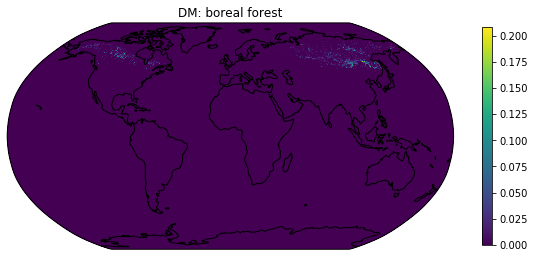

In [79]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.pcolormesh(lons, lats, dm_borf.sum(dim='month'), transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('DM: boreal forest')
fig.colorbar(p0, shrink=0.4);

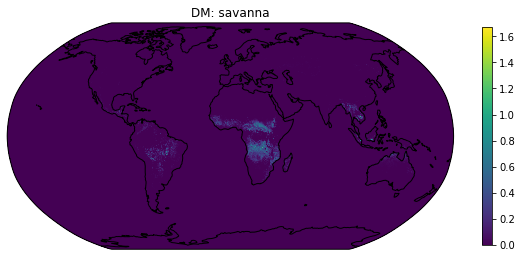

In [81]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.pcolormesh(lons, lats, dm_sava.sum(dim='month'), transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('DM: savanna')
fig.colorbar(p0, shrink=0.4);

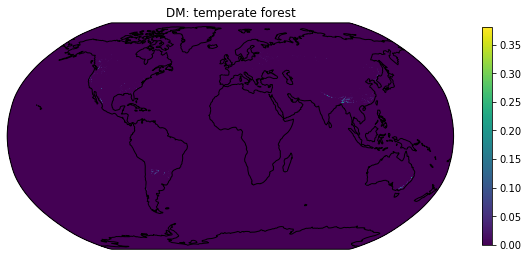

In [84]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.pcolormesh(lons, lats, dm_temf.sum(dim='month'), transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('DM: temperate forest')
fig.colorbar(p0, shrink=0.4);

In [85]:
# Calculate biomass burning emissions of alkyl nitrates in g m-2 month-1
meono2 = (dm_borf+dm_temf)*meono2_ef_borf + dm_sava*meono2_ef_sava # (dm_borf+dm_temf)*meono2_ef_borf + dm_sava*meono2_ef_sava
etono2 = (dm_borf+dm_temf)*etono2_ef_borf + dm_sava*etono2_ef_trof*(meono2_ef_sava/meono2_ef_trof)
nprono2 = (dm_borf+dm_temf)*nprono2_ef_borf + dm_sava*nprono2_ef_trof*(meono2_ef_sava/meono2_ef_trof)
iprono2 = (dm_borf+dm_temf)*iprono2_ef_borf + dm_sava*iprono2_ef_trof*(meono2_ef_sava/meono2_ef_trof)

In [ ]:
# If meono2_ef_sava is used for calculating tropical MeONO2 emissions (not meono2_ef_trof), global MeONO2 annual emission is about 1 Gg yr-1, which is too an order of ma

In [71]:
meono2_ef_sava/meono2_ef_trof*100

6.1519903498190605

In [66]:
((dm_sava*meono2_ef_sava).sum(dim='month')*grid_cell_area).sum()*1e-9

<xarray.DataArray ()>
array(1.461486)

In [67]:
((dm_sava*meono2_ef_trof).sum(dim='month')*grid_cell_area).sum()*1e-9

<xarray.DataArray ()>
array(23.756313)

In [63]:
((dm_sava*etono2_ef_trof).sum(dim='month')*grid_cell_area).sum()*1e-9

<xarray.DataArray ()>
array(16.334256)

In [70]:
((dm_sava*etono2_ef_trof*(meono2_ef_sava/meono2_ef_trof)).sum(dim='month')*grid_cell_area).sum()*1e-9

<xarray.DataArray ()>
array(1.004882)

In [46]:
def plt_gfed_map(arr, specie):
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
    p0 = ax.contourf(lons, lats, arr, transform=ccrs.PlateCarree(), cmap='Reds')
    ax.coastlines(color='grey', alpha=0.2)
    ax.set_title(f'{specie} biomass burning emissions')
    fig.colorbar(p0, shrink=0.4, label='g $m^{-2}$ $yr^{-1}$');

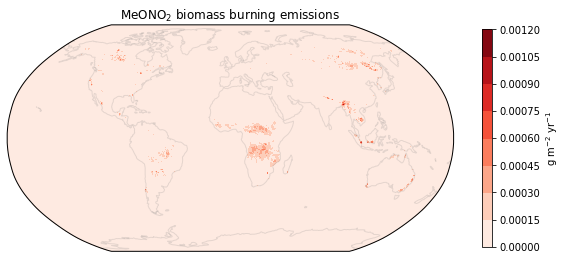

In [47]:
plt_gfed_map(meono2.sum(dim='month'), '$MeONO_2$')

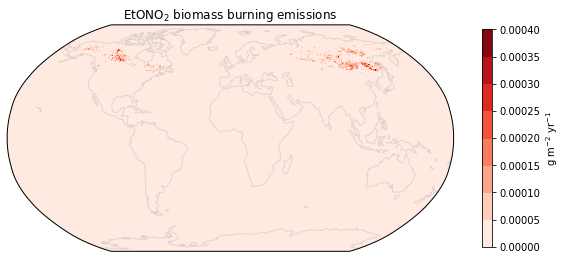

In [60]:
plt_gfed_map(etono2.sum(dim='month'), '$EtONO_2$')

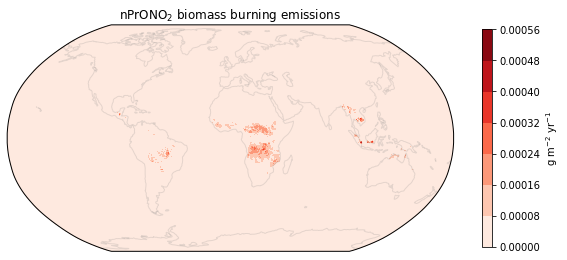

In [50]:
plt_gfed_map(nprono2.sum(dim='month'), '$nPrONO_2$')

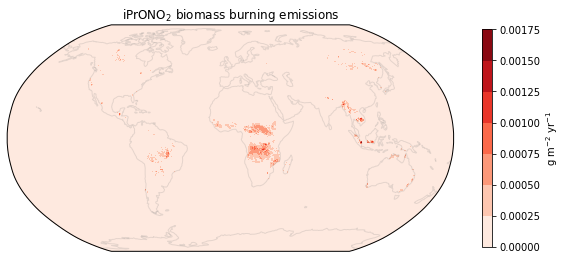

In [49]:
plt_gfed_map(iprono2.sum(dim='month'), '$iPrONO_2$')

#### Burden

In [86]:
(meono2.sum(dim='month')*grid_cell_area).sum()*1e-9

<xarray.DataArray ()>
array(1.907344)

In [87]:
(etono2.sum(dim='month')*grid_cell_area).sum()*1e-9

<xarray.DataArray ()>
array(1.285316)

In [88]:
(nprono2.sum(dim='month')*grid_cell_area).sum()*1e-9

<xarray.DataArray ()>
array(0.103776)

In [89]:
(iprono2.sum(dim='month')*grid_cell_area).sum()*1e-9

<xarray.DataArray ()>
array(0.685172)

In [90]:
(meono2.sum(dim='month')*grid_cell_area).sum()*1e-9 + (etono2.sum(dim='month')*grid_cell_area).sum()*1e-9 + (nprono2.sum(dim='month')*grid_cell_area).sum()*1e-9 +(iprono2.sum(dim='month')*grid_cell_area).sum()*1e-9

<xarray.DataArray ()>
array(3.981608)

Convert g to Tg: $\times$1e-12; g to Gg: $\times$1e-9.

From Simpson et al. (2002):

'...Based on these values, global savanna burning emissions for the five C1–C4 alkyl nitrates reported here are estimated to total roughly 6.6 Gg/yr (mainly as MeONO2) during the flaming stage, and 1.2 Gg/yr (mainly as C2–C4 alkyl nitrates) during the smoldering stage, for a total on the order of 8 Gg/yr (Table 3). For global biomass burning, summedC1–C4 alkyl nitrate emissions on the order of18 Gg/ yr are estimated. In both cases, MeONO2 emissions during the flaming stage comprise a majority (roughly two-thirds) of the total C1–C4 alkyl nitrate emissions. [16] 

The MeONO2 emissions from savanna and global biomass burning are estimated to total roughly 5.4 and 12.6 Gg/yr, respectively (Table 3). By comparison, for an atmos- phere of about 1.7 ? 1020 moles of air, a globally averaged MeONO2 mixing ratio of roughly 2 pptv, and a global MeONO2 lifetime of 0.1 yr, the global MeONO2 source is calculated to be on the order of 300 Gg/yr. That is, MeONO2 released from global biomass burning likely accounts for only a small portion (about 4%) of the global MeONO2 source.'